In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
def readtext(path):
    with open(path) as f:
        captions=f.read()
    return captions


In [4]:
captions=readtext("/content/drive/MyDrive/image_captions/captions.txt")
captions=captions.split('\n')[:-1]

In [5]:
print(len(captions))

40456


In [6]:
type(captions)

list

In [7]:
#Dictionary to map each image with the caption it has
descriptions={}
trainimage=set()
testimage=set()
validation=set()
x1=0
for i,j in enumerate(captions):
    x=j.split(',')
    first=x[0]
    if x1<5001:
        testimage.add(x[0])
        x1+=1
    else:
        trainimage.add(x[0])
        x1+=1
    second=x[1]
    img_name=first.split('.')[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [8]:
len(trainimage)

7091

In [9]:
len(descriptions.keys())

8092

In [10]:
descriptions

{'image': ['caption'],
 '1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on 

In [11]:
import pandas as pd

In [12]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
import cv2
import matplotlib.pyplot as plt

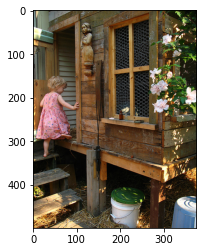

In [14]:
IMAGE_PATH='/content/drive/MyDrive/image_captions/images'
img=cv2.imread(IMAGE_PATH+'/1000268201_693b08cb0e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# DATA CLEANING

In [15]:
import re
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence =sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence
    
    

In [16]:
s="a man is sitting on the wall * 32"
clean_text(s)

'man is sitting on the wall'

In [17]:
for key,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i]=clean_text(captions_list[i])


In [18]:
#write description to a text file
with open("descriptions.txt",'w') as f:
    f.write(str(descriptions))

# VOCAB

In [19]:
#load our data as dictionary file
import json
descriptions=None
with open('descriptions.txt','r') as f:
    descriptions=f.read()
json_acceptable_string=descriptions.replace("'","\"")
description =json.loads(json_acceptable_string)

In [20]:
type(description)

dict

In [21]:
description

{'image': ['caption'],
 '1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting

In [22]:
#vocab
vocab=set()
for key in description.keys():
    [vocab.update(sentence.split()) for sentence in description[key]]


In [23]:
len(vocab)

8258

In [24]:
type(description)

dict

In [25]:
# Total no of words across all sentence
total_word=[]

for key in description.keys():
    [total_word.append(i) for des in description[key] for i in des.split()]
print("Total words %d"%len(total_word))    
    

Total words 357792


# Filter words(vocab) according to certain thershold(like remove words occurs less than 10)


In [26]:
import collections

counter=collections.Counter(total_word)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8258


In [27]:
#sort this dict acc. to freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter

threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_word=[x[0] for x in sorted_freq_cnt]

In [28]:
print(len(total_word))

1800


## Prepare Train/Test Data

In [29]:
train=list(trainimage)
test=list(testimage)

In [30]:
len(test)

1001

In [31]:
train=[row.split(".")[0] for row in train[:-1]]

In [32]:
test=[row.split(".")[0] for row in test[:-1]]

In [33]:
train[:5]

['3587077732_0933f1677b',
 '3356901257_83811a19eb',
 '2825483885_3f7c54db3e',
 '3044536048_e615466e7f',
 '2193223202_4d908c0450']

In [34]:
#Preapare description for training data
#tweak-add <s> and <e> token to our training data

train_desc={}

for img_id in train:
    train_desc[img_id]=[]
    for cap in description[img_id]:
        cap_to_append="startseq "+cap+" endseq"
        train_desc[img_id].append(cap_to_append)

In [ ]:
train_desc.pop('3523819210_99782628fc')

In [35]:
train_desc["3312096605_f458757418"]

['startseq two people sit on dock near the water endseq',
 'startseq two people sit on dock next to each other watching the sunset endseq',
 'startseq two people sit on the end of dock endseq',
 'startseq two people sit on the end of dock in the middle of still water endseq',
 'startseq two people sitting on dock endseq']

# Transfer Learning
Images --> Features

Text ---> Features

# Step - 1 Image Feature Extraction


In [36]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [37]:
model_new = Model(model.input,model.layers[-2].output)


In [38]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


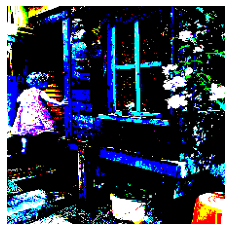

In [39]:
img = preprocess_img(IMAGE_PATH+"/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [40]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [41]:
encode_image(IMAGE_PATH+"/1000268201_693b08cb0e.jpg")


array([0.06535947, 0.16782546, 0.32517573, ..., 0.05107125, 0.32821143,
       1.004337  ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMAGE_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
!mkdir saved


In [ ]:
# Store everything to the disk 
with open("/content/drive/MyDrive/image_captions/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [42]:
test.remove('image')

In [43]:
test

['124195430_d14028660f',
 '1616016569_673de1d678',
 '181777261_84c48b31cb',
 '1969573381_5ecfae4c80',
 '1355945307_f9e01a9a05',
 '2073105823_6dacade004',
 '109671650_f7bbc297fa',
 '186890605_ddff5b694e',
 '1773928579_5664a810dc',
 '1160441615_fe6b3c5277',
 '1088767354_2acee738cf',
 '109738763_90541ef30d',
 '1234293791_6566284bcd',
 '1562392511_522a26063b',
 '1067790824_f3cc97239b',
 '1474474514_b3eb492722',
 '2089542487_b4c1ee7025',
 '1142283988_6b227c5231',
 '1342780478_bacc32344d',
 '1343426964_cde3fb54e8',
 '134894450_dadea45d65',
 '1473080948_bae2925dc8',
 '1260816604_570fc35836',
 '2095435987_1b7591d214',
 '1352410176_af6b139734',
 '197107117_4b438b1872',
 '1808504612_3508f3c9bb',
 '1056249424_ef2a2e041c',
 '1765164972_92dac06fa9',
 '162743064_bb242faa31',
 '1936215201_d03a75cbba',
 '1155138244_859fd6e079',
 '1457762320_7fe121b285',
 '1598085252_f3219b6140',
 '2098174172_e57d86ea03',
 '1574401950_6bedc0d29b',
 '2088532947_c628e44c4a',
 '1394368714_3bc7c19969',
 '1490213660_9ea4555

In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMAGE_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 254.02074313163757


In [ ]:
with open("/content/drive/MyDrive/image_captions/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)


In [45]:
# Getting the values back using pickle

with open("/content/drive/MyDrive/image_captions/encoded_train_features.pkl","rb") as f:
    encoding_train=pickle.load(f)

with open("/content/drive/MyDrive/image_captions/encoded_test_features.pkl","rb") as f:
    encoding_test=pickle.load(f)

# Data pre-processing for Captions


In [46]:
# Vocab
len(total_word)

1800

In [47]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_word):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [48]:
print(word_to_idx["dog"])
print(idx_to_word[1])
print(len(idx_to_word))

6
in
1800


In [49]:
# Two special words
idx_to_word[1801] = 'startseq'
word_to_idx['startseq'] = 1801

idx_to_word[1802] = 'endseq'
word_to_idx['endseq'] = 1802

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1803


In [50]:
max_len = 0 
for key in train_desc.keys():
    for cap in train_desc[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

30


In [ ]:
with open("/content/drive/MyDrive/image_captions/word_to_idx.pkl","wb") as f:
    pickle.dump(word_to idx,f)
    
with open("/content/drive/MyDrive/image_captions/idx_to_word.pkl","wb") as f:
    pickle.dump(idx_to_word,f)    

# Data Loader (Generator)


In [73]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield {'input_img':np.array(X1),'input_cap':np.array(X2)},np.array(y)
                    X1,X2,y = [],[],[]
                    n = 0

# Word Embeddings

In [52]:
f = open("/content/drive/MyDrive/image_captions/glove.6B.50d.txt",encoding='utf8')

In [53]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [54]:
f.close()

In [55]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [56]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [57]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1803, 50)

# Model Architecture

In [74]:
input_img_features = Input(shape=(2048,),name="input_img")
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)


In [75]:
# Captions as Input
input_captions = Input(shape=(max_len,),name="input_cap")
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [76]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [77]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cap (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_img (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 50)       90150       input_cap[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_img[0][0]                  
____________________________________________________________________________________________

In [78]:

# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [79]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training of Model

In [80]:
epochs = 15
batch_size = 3
steps = len(train_desc)//batch_size


In [81]:
steps


2363

In [99]:
for i in range(epochs):
    generator = data_generator(train_desc,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('/content/drive/MyDrive/image_captions/model_'+str(i)+'.h5')


   9/2363 [..............................] - ETA: 30s - loss: 4.1084

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


   5/2363 [..............................] - ETA: 30s - loss: 3.5956

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2363/2363 [==============================] - 33s 14ms/step - loss: 2.6564


In [105]:
model = load_model('/content/drive/MyDrive/image_captions/model_14.h5')


In [107]:
# Predictions

def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

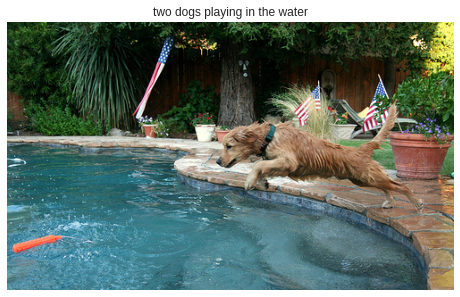

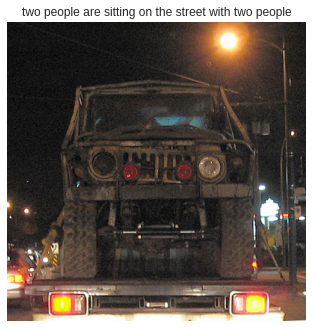

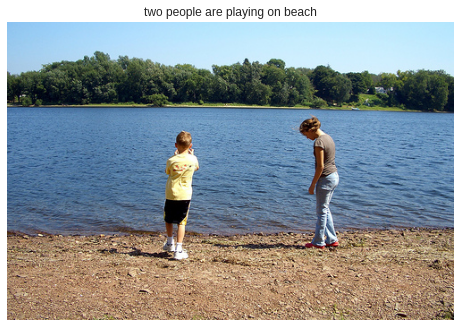

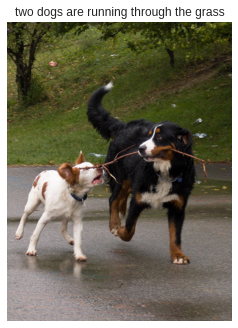

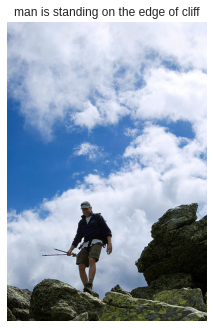

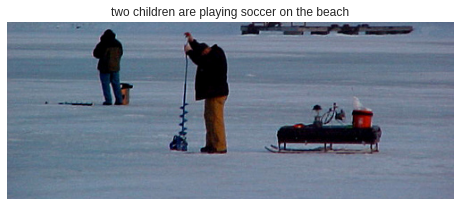

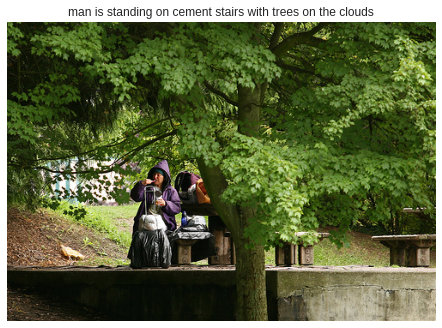

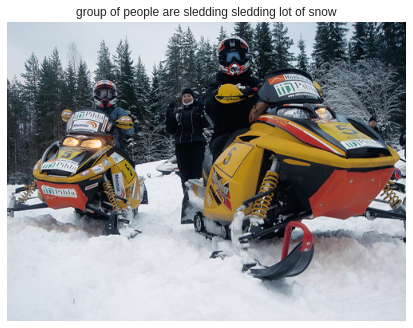

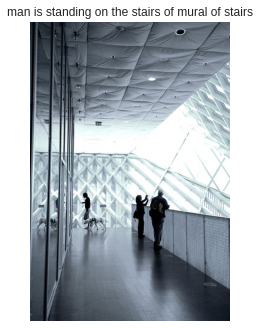

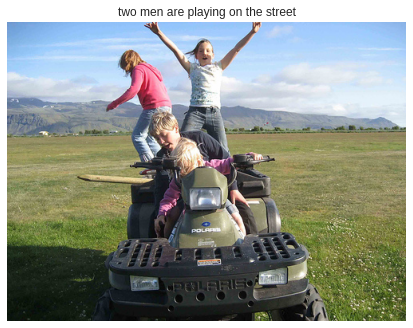

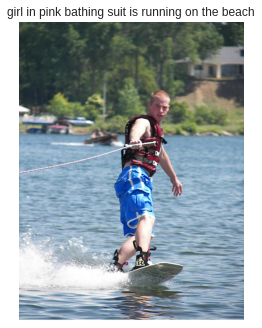

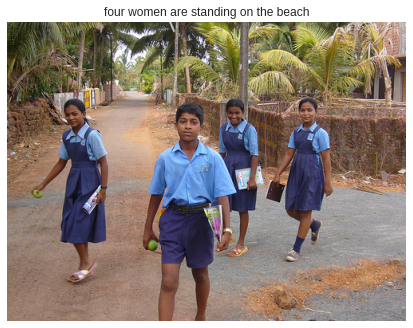

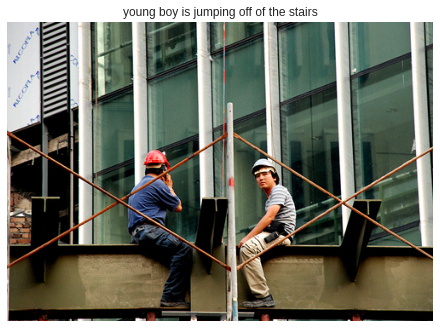

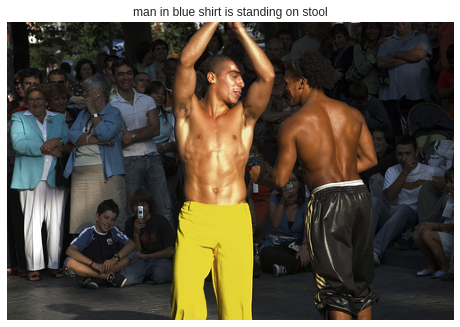

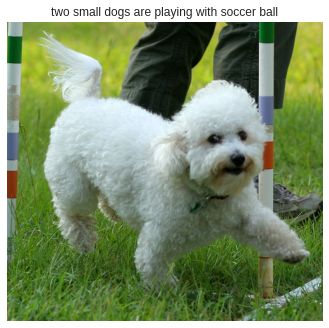

In [108]:
# Pick Some Random Images and See Results

plt.style.use("seaborn")

for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/MyDrive/image_captions/images/"+img_name+".jpg")

    caption = predict_caption(photo_2048)
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()